In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
COLORS = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#D55E00", "#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=COLORS)

In [2]:
def newtonMethodMultiDim(objective,
                         gradient,
                         hessian,
                         x0,
                         tolerance,
                         minima=True,
                         max_iterations=10000):
    """
    Implementation for the Newton's Method for unconstrained optimization problems i.e. 
    
    min f(x) or max f(x)
    s.t. x in R^n and f: R^n -> R

    Parameters
    ----------
    objective : function 
        The objective function for which the maximum/minima needs to be found.
    gradient : function
        The gradient of the objective function.
    hessian : function
        The hessian of the objective function.
    x0 : numpy array
        The initial guess for the maximum/minima.
    tolerance : float
        The tolerance for the stopping criteria.
    minima : bool
        If True, the algorithm will search for the minima, else it will 
        search for the maxima.
    max_iterations : int
        The maximum number of iterations for the algorithm if the algorithm
        does not converge.
    
    Returns
    -------
    optima : numpy array
        The optimal argument of the objective function.
    optimum : float
        The optimal value of the objective function.
    cache : tuple or None
        The cache is returned for the purpose of accessing the values of the 
        local variables of the algorithm for purposes like plotting or debugging.
    """

    cache = {"gradient_norms": [], 
             "objective_values": [], 
             "delta_xs": [], 
             "condition_numbers": []}

    iterator = x0
    for i in range(max_iterations):
        gradient_vector = gradient(iterator)
        gradient_norm = np.linalg.norm(gradient_vector)
        hessian_matrix = hessian(iterator)

        if gradient_norm < tolerance:
            return iterator, objective(iterator), cache
        
        # Update Equation
        delta_x = np.linalg.inv(hessian_matrix) @ gradient_vector
        iterator = iterator - delta_x

        cache["gradient_norms"].append(gradient_norm)
        cache["objective_values"].append(objective(iterator))
        cache["delta_xs"].append(np.linalg.norm(delta_x))
        cache["condition_numbers"].append(np.linalg.cond(hessian_matrix))

    return iterator, objective(iterator), cache
        

In [3]:
class ConvexFunction(object):
    """
    Class for representing the convex function 
    """

    def __init__(self):
        self.A = np.array([[2, 1, 0],[1, 2, 1],[0, 1, 2]])
        self.b = -np.array([[1],[1],[1]])
    
    def mainFunction(self, x):
        y = self.A @ x + self.b
        return np.sum(y**4 + y**2 + 1)

    def derivative(self, x):
        y = self.A @ x + self.b
        return self.A.T @ (4 * y**3 + 2 * y)

    def double_derivative(self, x):
        y = self.A @ x + self.b
        return self.A.T @ np.diag((12 * y**2 + 2).reshape(-1)) @ self.A

In [4]:
total_points = 100
starting_points = np.random.randn(total_points, 3)
caches = []
for starting_point in starting_points:
    starting_point = starting_point.reshape(-1, 1)
    optima, optimum, cache = newtonMethodMultiDim(ConvexFunction().mainFunction, ConvexFunction().derivative, ConvexFunction().double_derivative, starting_point, 1e-6)
    caches.append(cache)

In [5]:
gradient_norms = [cache["gradient_norms"] for cache in caches]
objective_values = [cache["objective_values"] for cache in caches]
delta_xs = [cache["delta_xs"] for cache in caches]
condition_numbers = [cache["condition_numbers"] for cache in caches]

In [6]:
iterations_length = np.array([len(gradient_norm) for gradient_norm in gradient_norms])
max_iterations = max(iterations_length)

gradient_norms = np.array([gradient_norm + [-np.inf]*(max_iterations - len(gradient_norm)) for gradient_norm in gradient_norms])
objective_values = np.array([objective_value + [-np.inf]*(max_iterations - len(objective_value)) for objective_value in objective_values])
delta_xs = np.array([delta_x + [-np.inf]*(max_iterations - len(delta_x)) for delta_x in delta_xs])
condition_numbers = np.array([condition_number + [-np.inf]*(max_iterations - len(condition_number)) for condition_number in condition_numbers])

In [7]:
def getRangeValues(values, total_points, iterations_length):
    """
    Returns the mean, max and min value vs the iteration number.

    Parameters
    ----------
    values : ndarray
        The values for which the mean, max and min values need to be calculated.
    """
    
    # Changing the -inf values to 0 so that they are not considered in the mean value calculation
    indices = np.isinf(values)
    values[indices] = 0
    # Dividing by the number of points to get the mean value
    mean_value = np.sum(values, axis=0)/(np.flip(np.cumsum(np.flip(np.bincount(iterations_length))))[1:])
    values[indices] = -np.inf
    max_value = np.max(values, axis=0)
    values[indices] = np.inf
    min_value = np.min(values, axis=0)

    return mean_value, max_value, min_value

In [8]:
def plotGraph(values, title, ylabel, xlabel):
    """
    Plots the graph for the values.

    Parameters
    ----------
    values : ndarray
        The values for which the graph needs to be plotted.
    title : str
        The title of the graph.
    ylabel : str
        The label for the y-axis.
    xlabel : str
        The label for the x-axis.
    """

    mean_value, max_value, min_value = getRangeValues(values, total_points, iterations_length)
    x = np.arange(1, len(mean_value)+1)
    plt.plot(x, mean_value, label="Mean", linewidth=2)
    plt.plot(x, max_value, label="Max", linewidth=2, color=COLORS[1])
    plt.plot(x, min_value, label="Min", linewidth=2, color=COLORS[1])
    plt.fill_between(x, min_value, max_value, alpha=0.5, color=COLORS[2])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

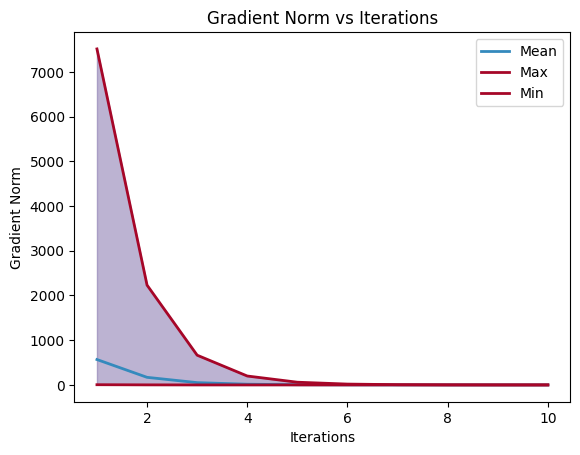

In [9]:
plotGraph(gradient_norms, "Gradient Norm vs Iterations", "Gradient Norm", "Iterations")

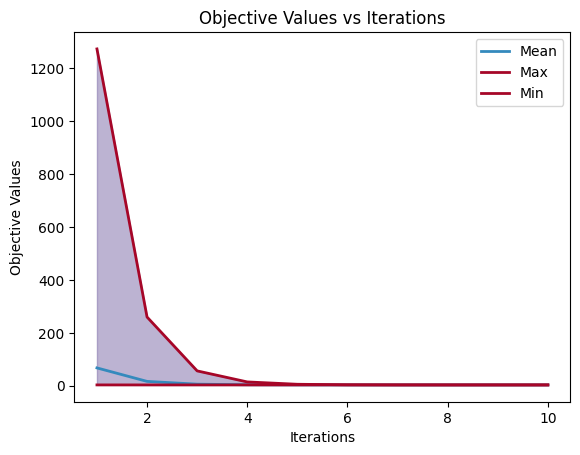

In [10]:
plotGraph(objective_values, "Objective Values vs Iterations", "Objective Values", "Iterations")

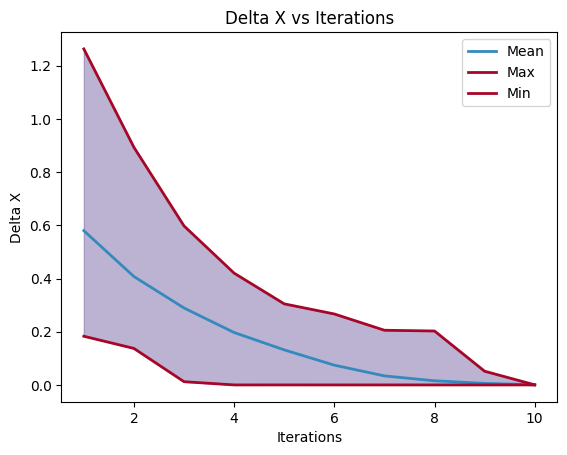

In [11]:
plotGraph(delta_xs, "Delta X vs Iterations", "Delta X", "Iterations")

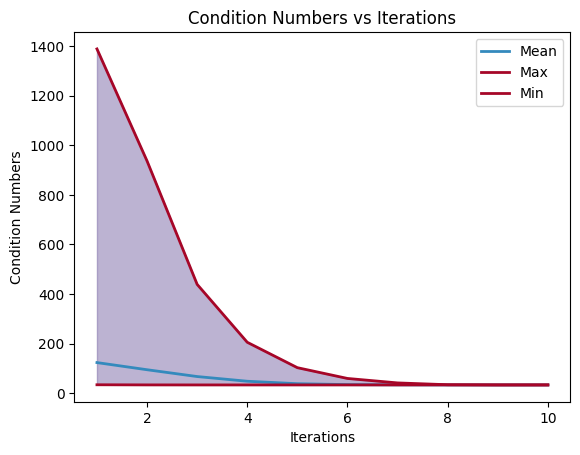

In [12]:
plotGraph(condition_numbers, "Condition Numbers vs Iterations", "Condition Numbers", "Iterations")